Import packages

In [45]:
using JuMP, HiGHS, Ipopt

Utility functions:

solve_evader_OCP - solve the optimal control problem where the evader avoids the pursuer with a cost x'*x and bounded turning rate

solve_pursuer_OCP - solve the optimal control problem where the pursuer tracks the evader with a cost x'*x and bounded turning rate

In [46]:
function solve_evader_OCP(model, sim_params, __pursuer, __evader)

    N = sim_params.N
    Δt = sim_params.Δt

    x_pursuer = __pursuer.x[1]
    y_pursuer = __pursuer.x[2]

    x0 = __evader.x[1]
    y0 = __evader.x[2]
    θ0 = __evader.x[3]

    v = __evader.v
    u_max = __evader.u_max

    # Decision variables
    @variable(model, x[1:N+1])      # x position
    @variable(model, y[1:N+1])      # y position
    @variable(model, θ[1:N+1])      # orientation
    @variable(model, ω[1:N])        # control input (turning rate)

    # Objective function (quadratic cost on position and control)
    @objective(model, Min, 
        -sum((x[k] - x_pursuer)^2 + (y[k] - y_pursuer)^2 for k in 1:N))

    # Initial conditions
    @constraint(model, x[1] == x0)
    @constraint(model, y[1] == y0)
    @constraint(model, θ[1] == θ0)

    # Dubins car dynamics constraints
    for k in 1:N
        @constraint(model, x[k+1] == x[k] + v * cos(θ[k]) * Δt)
        @constraint(model, y[k+1] == y[k] + v * sin(θ[k]) * Δt)
        @constraint(model, θ[k+1] == θ[k] + ω[k] * Δt)

        # bounded control input
        @constraint(model, -u_max <= ω[k] <= u_max)

    end

    # Solve the optimization problem
    optimize!(model)

    # Extract results
    x_opt = value.(x)
    y_opt = value.(y)
    θ_opt = value.(θ)
    ω_opt = value.(ω)

    return x_opt,y_opt,θ_opt,ω_opt
end

function solve_pursuer_OCP(model, sim_params, __pursuer, __evader)
    N = sim_params.N
    Δt = sim_params.Δt

    x_evader = __evader.x[1]
    y_evader = __evader.x[2]
    θ_evader = __evader.x[3]

    x0 = __pursuer.x[1]
    y0 = __pursuer.x[2]
    θ0 = __pursuer.x[3]

    v = __pursuer.v
    u_max = __pursuer.u_max

    # Decision variables
    @variable(model, x[1:N+1])      # x position
    @variable(model, y[1:N+1])      # y position
    @variable(model, θ[1:N+1])      # orientation
    @variable(model, ω[1:N])        # control input (turning rate)

    # Objective function (quadratic cost on position and control)
    @objective(model, Min, 
        sum((x[k] - x_evader)^2 + (y[k] - y_evader)^2 for k in 1:N))

    # Initial conditions
    @constraint(model, x[1] == x0)
    @constraint(model, y[1] == y0)
    @constraint(model, θ[1] == θ0)

    # Dubins car dynamics constraints
    for k in 1:N
        @constraint(model, x[k+1] == x[k] + v * cos(θ[k]) * Δt)
        @constraint(model, y[k+1] == y[k] + v * sin(θ[k]) * Δt)
        @constraint(model, θ[k+1] == θ[k] + ω[k] * Δt)

        # bounded control input
        @constraint(model, -u_max <= ω[k] <= u_max)
    end
    
    # Solve the optimization problem
    optimize!(model)

    # Extract results
    x_opt = value.(x)
    y_opt = value.(y)
    θ_opt = value.(θ)
    ω_opt = value.(ω)

    return x_opt,y_opt,θ_opt,ω_opt
end

solve_pursuer_OCP (generic function with 1 method)

In [47]:
include("dynamics\\DubinsCar.jl")

@kwdef mutable struct Parameters
    N::Int64
    Δt::Float64
    T::Int64
end

# Parameters
T = 20                   # Total sim time [seconds]
Δt = 0.1                 # Time step
N = 0.2*(T/Δt)           # Time horizon

x0_pursuer = 3.0         # adversary x position
y0_pursuer = 3.0         # adversary y position
θ0_pursuer = pi/2        # adversary orientation
v_pursuer= 1.0           # Fixed pursuer forward velocity
up_max = 1.5

x0_evader = 3.5         # Initial evader x position
y0_evader = 3.0          # Initial evader y position
θ0_evader = pi/4         # Initial evader orientation
v_evader = 1.5           # Fixed evader forward velocity
ue_max = 1.5

pursuer_init_state = Vector{Float64}([x0_pursuer, y0_pursuer, θ0_pursuer])
evader_init_state = Vector{Float64}([x0_evader, y0_evader, θ0_evader])



sim_params = Parameters(N,Δt,T)

# pursuer and evader objects
__pursuer = Dubins_Car(f,v_pursuer,pursuer_init_state,up_max)
__evader = Dubins_Car(f,v_evader,evader_init_state,ue_max)

evader_model = Model(Ipopt.Optimizer)
pursuer_model = Model(Ipopt.Optimizer)


A JuMP Model
├ solver: Ipopt
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

In [48]:
x_opt,y_opt,θ_opt,ω_opt = solve_evader_OCP(evader_model, sim_params, __pursuer, __evader);
xp_opt, yp_opt, θp_opt, ωp_opt = solve_pursuer_OCP(pursuer_model, sim_params, __pursuer, __evader);

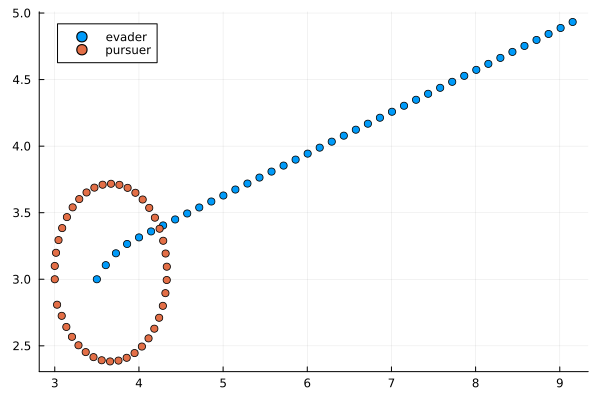

In [49]:
using Plots

plot(x_opt, y_opt, seriestype=:scatter,label="evader")
plot!(xp_opt, yp_opt, seriestype=:scatter,label="pursuer")

Implement MPC finite-horizon simulation of pursuer/evader

In [50]:
K = Int64(sim_params.T / sim_params.Δt)
xₚ = fill(0.0f0, (3,K))
xₑ = fill(0.0f0, (3,K))

xₚ[:,1] = pursuer_init_state
xₑ[:,1] = evader_init_state


for t in 1:K-1

    ## Solve the optimal control problem for both pursuer and evader
    evader_model = Model(Ipopt.Optimizer)
    pursuer_model = Model(Ipopt.Optimizer)

    _,_,_,ue_opt = solve_evader_OCP(evader_model, sim_params, __pursuer, __evader);
    _,_,_,up_opt = solve_pursuer_OCP(pursuer_model, sim_params, __pursuer, __evader);

    ## Extract the first optimal control value
    uₑ = ue_opt[1]
    uₚ = up_opt[1]

    ## Update dubins car
    xₑ_kplus1 = __evader.f(Vector{Float64}(xₑ[:,t]),uₑ,0.0,__evader.v,Δt)
    xₚ_kplus1  = __pursuer.f(Vector{Float64}(xₚ[:,t]),uₚ,0.0,__pursuer.v,Δt)

    xₑ[:,t+1] = xₑ_kplus1
    xₚ[:,t+1] = xₚ_kplus1

    __evader.x = xₑ_kplus1
    __pursuer.x = xₚ_kplus1

    println(t)
end




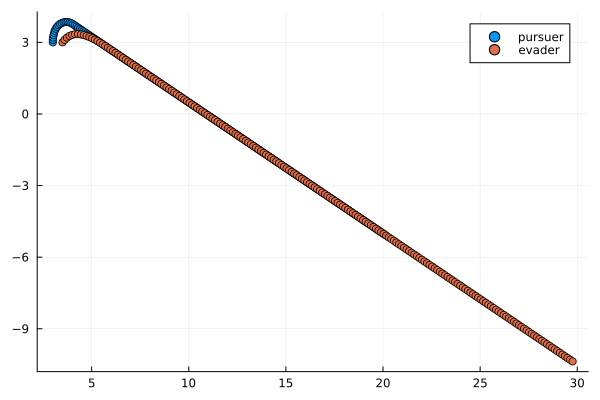

In [51]:
plot(xₚ[1,:],xₚ[2,:],seriestype=:scatter,label="pursuer")
plot!(xₑ[1,:],xₑ[2,:],seriestype=:scatter,label="evader")